# **Gaussian process Toy problem**

Given a set of N points in d=4 dimensions with correlation matrix $\Sigma$, their values y with some error, do a Gaussian process to find a function with error bars, and predict the value of a new point. 

1) Generate N 4-dimensional points with a certain correlation matrix
2) Compare two methods for space-filling sampling
3) Compare training for three different functions: simple, normal, and complex. Check the normality of the predictions. Compare how the number of training points affects the fit. Measure "goodness of fit".
4) 

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
# from mpl_toolkits.mploties3d import Axes3D
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.metrics import r2_score, mean_absolute_error

np.random.seed(1234)

In [2]:
# --------------------------------------------------------------
# 1. True 4D test function (highly non-linear)
# --------------------------------------------------------------
def true_function(X):
    """
    X: array of shape (n_samples, 4)
    A combination of Rastrigin (scaled) and sinusoids
    """
    x1, x2, x3, x4 = X[:, 0], X[:, 1], X[:, 2], X[:, 3]
    return (np.sin(3 * x3) * np.cos(4 * x4) +
            0.5 * np.sin(5 * x3 + x4) +
            0.1 * (x1**2 + x2**2 + x3**2 + x4**2 - 10 * np.cos(2*np.pi*np.stack([x1,x2,x3,x4], axis=0))).sum(axis=0))


def f_simple(X):
    x1, x2, x3, x4 = X[:,0], X[:,1], X[:,2], X[:,3]
    return 0.5*x1 + 0.2*x2 - 0.3*x3 + 0.1*x4

def f_normal(X):
    x1, x2, x3, x4 = X[:,0], X[:,1], X[:,2], X[:,3]
    return (
        np.sin(x1) * np.cos(0.5*x2) +
        0.3 * np.sin(2*x3) +
        0.05*(x1**2 + x2**2 + x3**2 + x4**2)
    )
def f_complicated(X):
    x1, x2, x3, x4 = X[:,0], X[:,1], X[:,2], X[:,3]

    # Rastrigin-like term for multi-modality
    ras = (x1**2 - 10*np.cos(2*np.pi*x1) +
           x2**2 - 10*np.cos(2*np.pi*x2) +
           x3**2 - 10*np.sin(2*np.pi*x3) +
           x4**2 - 10*np.sin(2*np.pi*x4))

    # Nonlinear interactions
    cross = np.sin(3*x1*x2) + 0.4*np.cos(2*x3*x4)

    # High frequency terms
    osc = 0.2*np.sin(5*x1 + x3) + 0.2*np.sin(4*x2 - x4)

    return 0.1*ras + cross + osc
# Bounds for each dimension
bounds = np.array([[-2, 2], [-2, 2], [-2, 2], [-2, 2]])

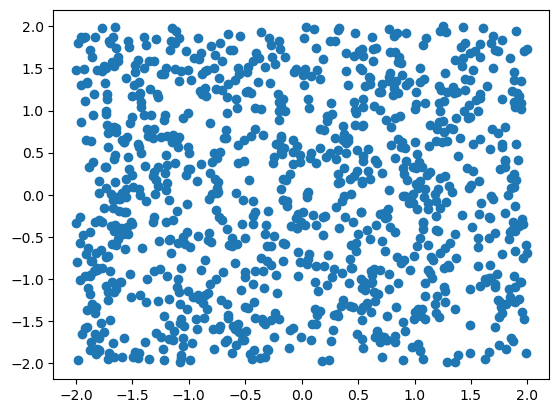

In [16]:
f="f_complicated"

# --------------------------------------------------------------
# 2. Training data (Latin Hypercube would be better for 4D, here random for simplicity)
# --------------------------------------------------------------
np.random.seed(42)
n_train = 1000
X_train = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_train, 4))
if f=="f_simple":
    y_train=f_simple(X_train).ravel()
elif f=="f_normal":
    y_train=f_normal(X_train).ravel()
else:
    y_train=f_complicated(X_train).ravel()
# y_train = true_function(X_train).ravel()

# Add a tiny noise
y_train += np.random.normal(0, 0.1, size=y_train.shape)

X_train.shape, y_train.shape

plt.scatter(X_train[:,2],X_train[:,3])

In [4]:
# --------------------------------------------------------------
# 3. Fit Gaussian Process 
# --------------------------------------------------------------
kernel = C(1.0) * RBF(length_scale=[1.0]*4, length_scale_bounds=(1e-2, 1e2)) + WhiteKernel(noise_level=1e-2)
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-10, normalize_y=True, n_restarts_optimizer=5)
gp.fit(X_train, y_train)

print("Fitted kernel:", gp.kernel_)
print("Log-marginal-likelihood:", gp.log_marginal_likelihood_value_)

Fitted kernel: 0.934**2 * RBF(length_scale=[0.311, 0.312, 8, 7.14]) + WhiteKernel(noise_level=0.377)
Log-marginal-likelihood: -1123.4917616721048


In [5]:
# --------------------------------------------------------------
# 4. Prediction on a regular grid (we fix x3 and x4 for visualization)
# --------------------------------------------------------------
n_grid = 50
x1 = np.linspace(-2, 2, n_grid)
x2 = np.linspace(-2, 2, n_grid)
X1, X2 = np.meshgrid(x1, x2)

def predict_slice(x3_fixed=0.0, x4_fixed=0.0):
    """Predict mean and std on a 2D slice with x3,x4 fixed"""
    X_grid = np.column_stack([X1.ravel(), X2.ravel(),
                              np.full(X1.size, x3_fixed),
                              np.full(X1.size, x4_fixed)])
    y_mean, y_std = gp.predict(X_grid, return_std=True)
    print(X_grid.shape)
    return y_mean.reshape(X1.shape), y_std.reshape(X1.shape)

# Choose a few interesting slices
slices = [
    ("x3=1.0, x4=0.0", 1.0, 0.0),
    ("x3=1.0, x4=-1.0", 1.0, -1.0),
    ("x3=-1.5, x4=1.5", -1.5, 1.5),
]


1.0 0.0
(2500, 4)
1.0 -1.0
(2500, 4)
-1.5 1.5
(2500, 4)


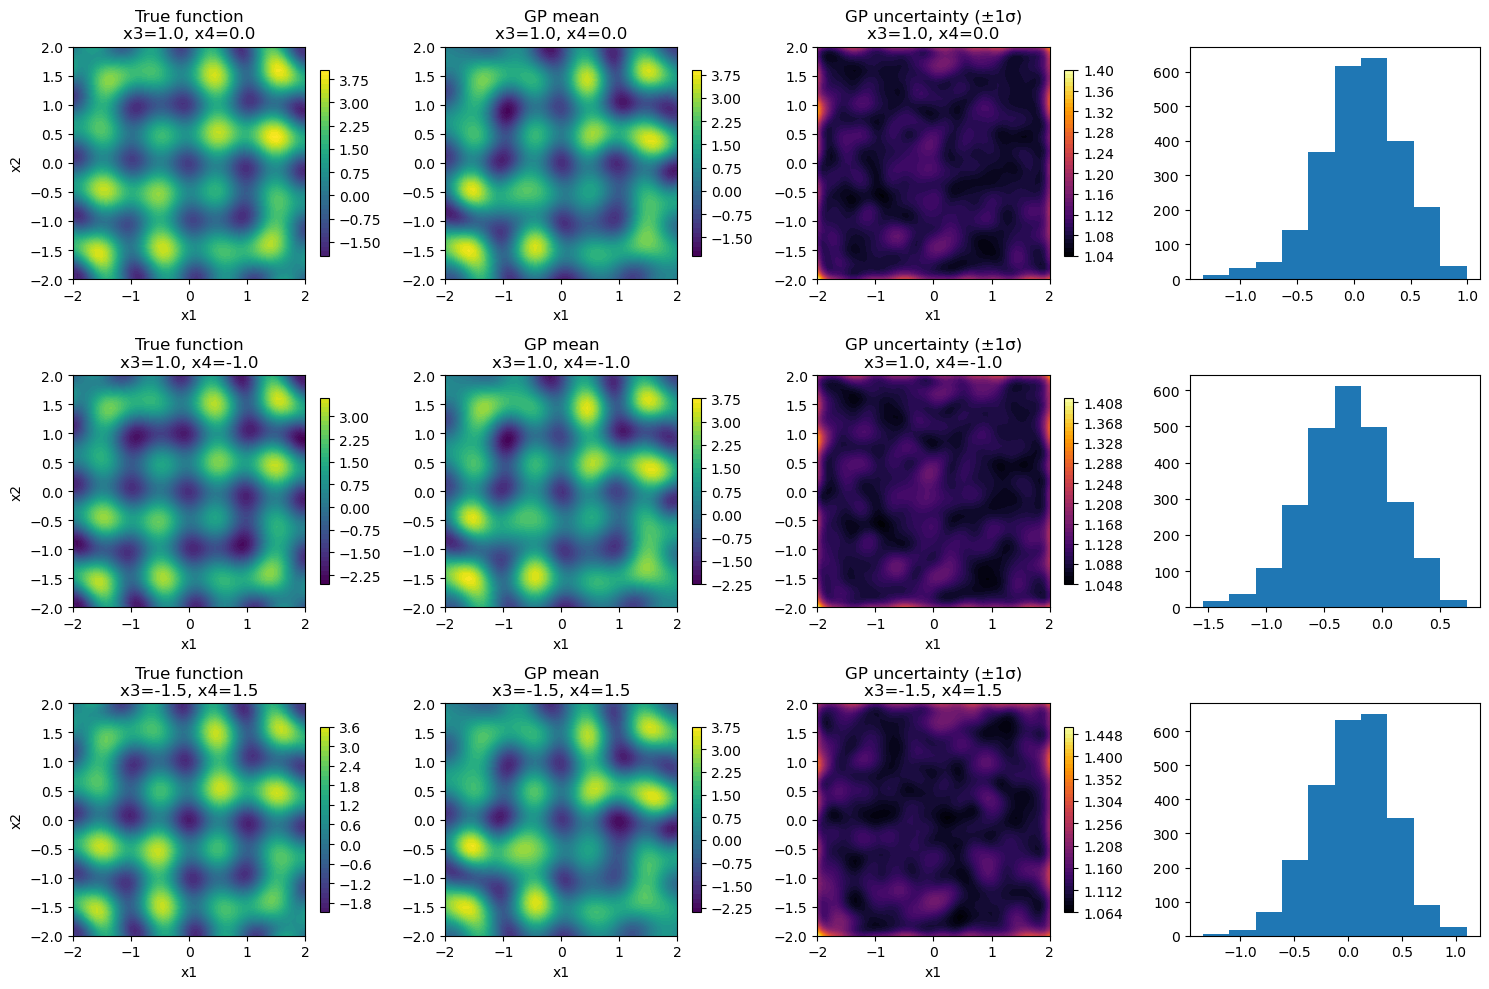

In [15]:
# --------------------------------------------------------------
# 5. Plotting
# --------------------------------------------------------------

fig = plt.figure(figsize=(15, 10))

for i, (title, x3f, x4f) in enumerate(slices, 1):
    print(x3f,x4f)
    y_mean, y_std = predict_slice(x3f, x4f)
    X_test=np.column_stack([X1.ravel(), X2.ravel(), np.full_like(X1.ravel(), x3f), np.full_like(X1.ravel(), x4f)])
    if f=="f_simple":
        y_true=f_simple(X_test).reshape(X1.shape)
    elif f=="f_normal":
        y_true=f_normal(X_test).reshape(X1.shape)
    else:
        y_true=f_complicated(X_test).reshape(X1.shape)

    
    # y_true = true_function(np.column_stack([X1.ravel(), X2.ravel(), np.full_like(X1.ravel(), x3f), np.full_like(X1.ravel(), x4f)])).reshape(X1.shape)
    # contour_levels = [0.2, 0.4, 0.6, 0.8, 1.0]
    # True function contour
    ax1 = fig.add_subplot(3, 4, 4*(i-1)+1)
    cp1 = ax1.contourf(X1, X2, y_true, levels=50, cmap='viridis', vmin=global_vmin, vmax=global_vmax)
    plt.colorbar(cp1, ax=ax1, shrink=0.8)
    ax1.set_title(f'True function\n{title}')
    ax1.set_xlabel('x1'); ax1.set_ylabel('x2')

    # GP mean
    ax2 = fig.add_subplot(3, 4, 4*(i-1)+2)
    cp2 = ax2.contourf(X1, X2, y_mean, levels=50, cmap='viridis')
    plt.colorbar(cp2, ax=ax2, shrink=0.8)
    ax2.set_title(f'GP mean\n{title}')
    ax2.set_xlabel('x1')

    # GP uncertainty (std)
    ax3 = fig.add_subplot(3, 4, 4*(i-1)+3)
    cp3 = ax3.contourf(X1, X2, y_std, levels=50, cmap='inferno')
    plt.colorbar(cp3, ax=ax3, shrink=0.8)
    ax3.set_title(f'GP uncertainty (±1σ)\n{title}')
    ax3.set_xlabel('x1')

    
    ax4 = fig.add_subplot(3, 4, 4*(i-1)+4)
    hist=ax4.hist((y_true.ravel()-y_mean.ravel())/y_std.ravel(), bins=10)
    
    # # 3D surface of GP mean for the first slice only (to save space)
    # if i == 1:
    #     ax4 = fig.add_subplot(3, 4, 4, projection='3d')
    #     surf = ax4.plot_surface(X1, X2, y_mean, cmap='viridis', alpha=0.8)
    #     ax4.set_title('GP mean (3D surface)\nx3=0, x4=0')
    #     ax4.set_xlabel('x1'); ax4.set_ylabel('x2'); ax4.set_zlabel('y')

plt.tight_layout()
plt.show()

Fitted kernel: 14.8**2 * RBF(length_scale=[30.1, 56.6, 34.3, 85.4]) + WhiteKernel(noise_level=0.0258)
Log-marginal-likelihood: 20.68666988287383


C:\Users\17874\.conda\envs\2025-env\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Fitted kernel: 0.981**2 * RBF(length_scale=[1.82, 2.79, 1.25, 100]) + WhiteKernel(noise_level=0.0276)
Log-marginal-likelihood: -10.454653627654622


C:\Users\17874\.conda\envs\2025-env\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Fitted kernel: 1**2 * RBF(length_scale=[1.51, 0.249, 0.175, 5.71]) + WhiteKernel(noise_level=1e-05)
Log-marginal-likelihood: -131.2805537745805


C:\Users\17874\.conda\envs\2025-env\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Fitted kernel: 18.7**2 * RBF(length_scale=[45.7, 84.8, 64.5, 100]) + WhiteKernel(noise_level=0.0195)
Log-marginal-likelihood: 248.96260741893013
Fitted kernel: 1.11**2 * RBF(length_scale=[2.01, 3.24, 1.56, 5.23]) + WhiteKernel(noise_level=0.0186)
Log-marginal-likelihood: 170.3008020626287


C:\Users\17874\.conda\envs\2025-env\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Fitted kernel: 0.852**2 * RBF(length_scale=[0.237, 0.249, 5.66, 100]) + WhiteKernel(noise_level=0.326)
Log-marginal-likelihood: -585.0117669866447


C:\Users\17874\.conda\envs\2025-env\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Fitted kernel: 19.3**2 * RBF(length_scale=[54.6, 91.1, 71.3, 100]) + WhiteKernel(noise_level=0.0179)
Log-marginal-likelihood: 563.9440057474321
Fitted kernel: 1.25**2 * RBF(length_scale=[2.09, 3.38, 1.55, 5.68]) + WhiteKernel(noise_level=0.0198)
Log-marginal-likelihood: 395.29649149077113
Fitted kernel: 0.93**2 * RBF(length_scale=[0.312, 0.285, 18.1, 11.3]) + WhiteKernel(noise_level=0.379)
Log-marginal-likelihood: -1113.2065332737288


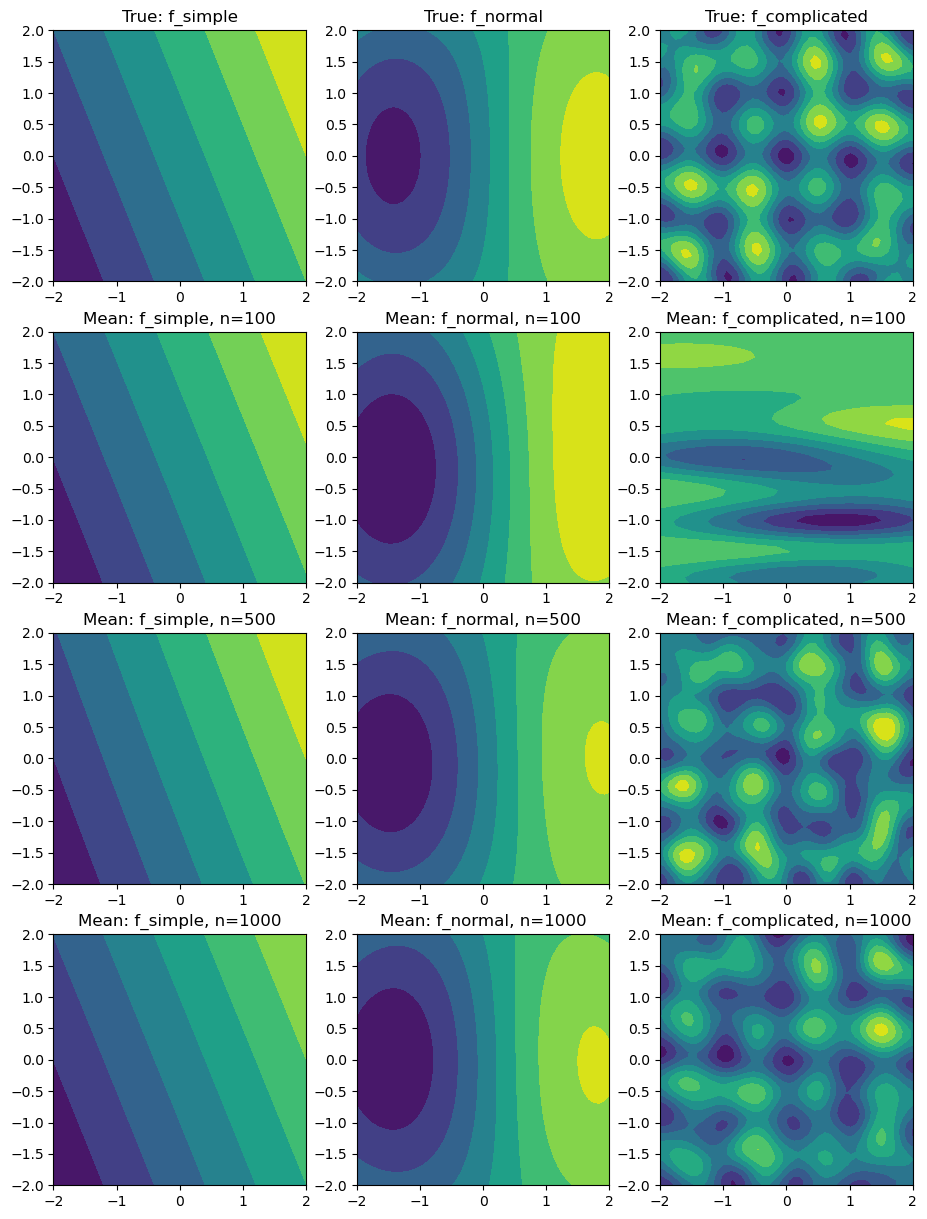

In [24]:
#Now let's compare the model for different functions, different training points   
nrows = 4
ncols = 4
functions=["f_simple", "f_normal","f_complicated"]
train_ptx=[100,500,1000]
X_grid = np.column_stack([X1.ravel(), X2.ravel(),
                          np.full(X1.size, 1),
                          np.full(X1.size, 1)])

fig = plt.figure(figsize=(15, 15))

row = 0
for col, func in enumerate(functions):
    idx = row * ncols + col + 1   # subplot index
    ax = fig.add_subplot(nrows, ncols, idx)
    X_test=np.column_stack([X1.ravel(), X2.ravel(), np.full_like(X1.ravel(), x3f), np.full_like(X1.ravel(), x4f)])
    
    if func=="f_simple":
        y_true=f_simple(X_test).reshape(X1.shape)
    elif func=="f_normal":
        y_true=f_normal(X_test).reshape(X1.shape)
    else:
        y_true=f_complicated(X_test).reshape(X1.shape)
        
    ax.contourf(X1, X2, y_true, cmap='viridis')
    ax.set_title(f"True: {func}")

for r, n in enumerate(train_ptx, start=1):
    row = r   # row 1, 2, 3 → subplot rows 2,3,4 in figure

    for col, func in enumerate(functions):
        idx = row * ncols + col + 1
        ax = fig.add_subplot(nrows, ncols, idx)

         # Generating training points
        X_train = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n, 4))
        if func=="f_simple":
            y_train=f_simple(X_train).ravel()
        elif func=="f_normal":
            y_train=f_normal(X_train).ravel()
        else:
            y_train=f_complicated(X_train).ravel()
        # y_train = true_function(X_train).ravel()
        
        # Add a tiny noise
        y_train += np.random.normal(0, 0.1, size=y_train.shape)


        #Training: 
        kernel = C(1.0) * RBF(length_scale=[1.0]*4, length_scale_bounds=(1e-2, 1e2)) + WhiteKernel(noise_level=1e-2)
        gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-10, normalize_y=True, n_restarts_optimizer=5)
        gp.fit(X_train, y_train)

        print("Fitted kernel:", gp.kernel_)
        print("Log-marginal-likelihood:", gp.log_marginal_likelihood_value_)


        y_mean, y_std = gp.predict(X_grid, return_std=True)
        ax.contourf(X1, X2, y_mean.reshape(X1.shape), cmap='viridis')
        plt.colorbar(cp3, ax=ax, shrink=0.8)
        ax.set_title(f"Mean: {func}, n={n}")

    # # histogram goes in column 3 (index = 3) of this row
    # col = 3
    # idx = row * ncols + col + 1
    # ax = fig.add_subplot(nrows, ncols, idx)
    # ax.hist((y_true.ravel()-y_mean.ravel())/y_std.ravel(), bins=20)
    # ax.set_title(f"Residuals, n={n}")




# for i, fn in enumerate(functions):


            
#     for n in  train_ptx:
#         # Generating training points
#         X_train = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n, 4))
#         if fn=="f_simple":
#             y_train=f_simple(X_train).ravel()
#         elif fn=="f_normal":
#             y_train=f_normal(X_train).ravel()
#         else:
#             y_train=f_complicated(X_train).ravel()
#         # y_train = true_function(X_train).ravel()
        
#         # Add a tiny noise
#         y_train += np.random.normal(0, 0.1, size=y_train.shape)


#         #Training: 
#         kernel = C(1.0) * RBF(length_scale=[1.0]*4, length_scale_bounds=(1e-2, 1e2)) + WhiteKernel(noise_level=1e-2)
#         gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-10, normalize_y=True, n_restarts_optimizer=5)
#         gp.fit(X_train, y_train)

#         print("Fitted kernel:", gp.kernel_)
#         print("Log-marginal-likelihood:", gp.log_marginal_likelihood_value_)

        


            
#         y_mean, y_std = gp.predict(X_grid, return_std=True)
        
#         ax2 = fig.add_subplot(3, 4, 4*(i-1)+2)
#         cp2 = ax2.contourf(X1, X2, y_mean, levels=50, cmap='viridis')
#         plt.colorbar(cp2, ax=ax2, shrink=0.8)
#         ax2.set_title(f'GP mean\n{title}')
#         ax2.set_xlabel('x1')
        





# # Let's pick a fresh random point in the 4D space that we haven't seen before
# np.random.seed(1234)  # for reproducibility
# x_new = np.random.uniform(-2, 2, size=4).round(4)

# print("New 4D point to predict:")
# print(f"x = [{x_new[0]}, {x_new[1]}, {x_new[2]}, {x_new[3]}]")

# # GP prediction (mean ± 1.96σ for 95% CI)
# y_pred, y_std = gp.predict(x_new.reshape(1, -1), return_std=True)

# print("\nGaussian Process prediction:")
# print(f"Predicted value: {y_pred[0]:.4f} ± {1.96*y_std[0]:.4f}  (95% confidence interval)")

# # True underlying value (unknown in real life, but we have it here for checking)
# y_true = true_function(x_new.reshape(1, -1))[0]

# print("\nTrue function value at this point:")
# print(f"y_true = {y_true:.4f}")

# # Is the true value inside the 95% CI?
# inside = y_pred[0] - 1.96*y_std[0] <= y_true <= y_pred[0] + 1.96*y_std[0]
# print(f"\nTrue value is inside the 95% CI? → {inside}")

C:\Users\17874\.conda\envs\2025-env\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 2 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\17874\.conda\envs\2025-env\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Optimized kernel: 0.621**2 * RBF(length_scale=[0.211, 3.31, 100, 100]) + WhiteKernel(noise_level=0.698)


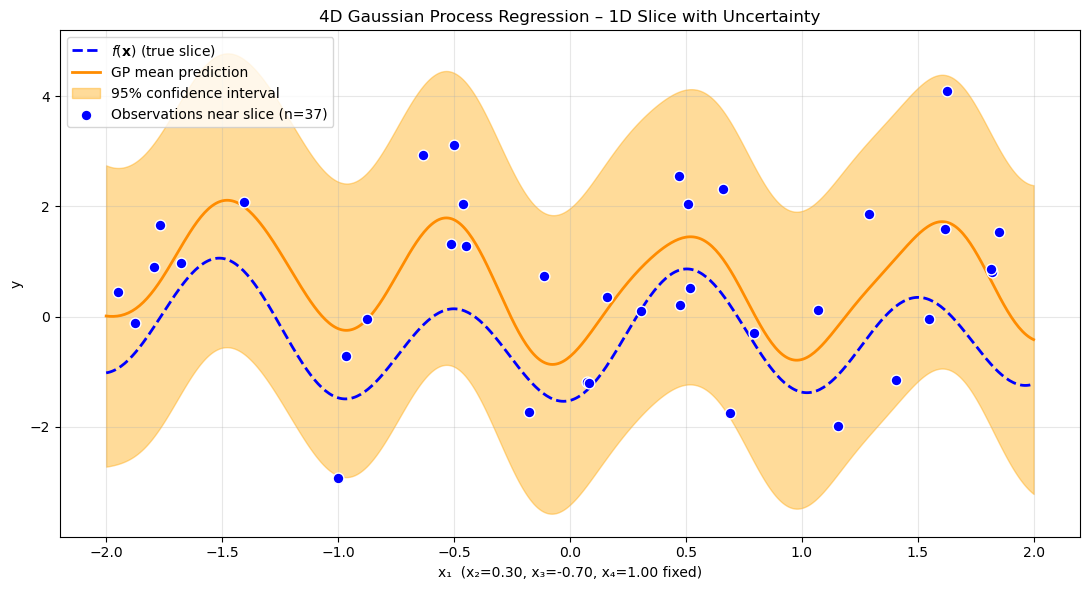

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel

# ------------------------------------------------------------
# Correct 4D test function (no broadcasting bugs)
# ------------------------------------------------------------
def true_function(X):
    """
    X: (n_samples, 4) array
    Returns: (n_samples,) array
    """
    x1, x2, x3, x4 = X[:, 0], X[:, 1], X[:, 2], X[:, 3]
    
    # Nice smooth part
    term1 = np.sin(3 * x1) * np.cos(4 * x2)
    term2 = 0.5 * np.sin(5 * x3 + x4)
    
    # Scaled Rastrigin-like multimodality (applied correctly)
    rastrigin = (x1**2 - 10 * np.cos(2 * np.pi * x1)) + \
                (x2**2 - 10 * np.cos(2 * np.pi * x2)) + \
                (x3**2 - 10 * np.cos(2 * np.pi * x3)) + \
                (x4**2 - 10 * np.cos(2 * np.pi * x4))
    
    return term1 + term2 + 0.1 * rastrigin

# ------------------------------------------------------------
# Training data
# ------------------------------------------------------------
np.random.seed(42)
n_train = 300
X_train = np.random.uniform(-2, 2, size=(n_train, 4))
y_train = true_function(X_train) + np.random.normal(0, 0.15, size=n_train)

# ------------------------------------------------------------
# Fit GP (works perfectly in 4D)
# ------------------------------------------------------------
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=[1.0]*4, length_scale_bounds=(1e-2, 1e2)) + WhiteKernel(1e-2)
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True, n_restarts_optimizer=10)
gp.fit(X_train, y_train)

print("Optimized kernel:", gp.kernel_)

# ------------------------------------------------------------
# Beautiful 1D slice plot exactly like scikit-learn docs
# ------------------------------------------------------------
# Choose a slice by fixing x2, x3, x4
fix_x2, fix_x3, fix_x4 = 0.3, -0.7, 1.0

x1_test = np.linspace(-2, 2, 500).reshape(-1, 1)
X_test = np.hstack([
    x1_test,
    np.full((500, 1), fix_x2),
    np.full((500, 1), fix_x3),
    np.full((500, 1), fix_x4)
])

y_true_slice = true_function(X_test)
y_mean, y_std = gp.predict(X_test, return_std=True)

plt.figure(figsize=(11, 6))

# True underlying function (dashed blue)
plt.plot(x1_test, y_true_slice, 'b--', lw=2, label=r'$f(\mathbf{x})$ (true slice)')

# GP mean (solid orange)
plt.plot(x1_test, y_mean, 'darkorange', lw=2, label='GP mean prediction')

# 95% confidence interval (orange band)
plt.fill_between(x1_test.ravel(),
                 y_mean - 1.96 * y_std,
                 y_mean + 1.96 * y_std,
                 color='orange', alpha=0.4, label='95% confidence interval')

# Training points close to this slice
tol = 1
mask = (np.abs(X_train[:,1] - fix_x2) < tol) & \
       (np.abs(X_train[:,2] - fix_x3) < tol) & \
       (np.abs(X_train[:,3] - fix_x4) < tol)

plt.scatter(X_train[mask, 0], y_train[mask],
            c='blue', s=60, edgecolors='white', linewidth=1, zorder=5,
            label=f'Observations near slice (n={mask.sum()})')

plt.xlabel('x₁  (x₂=%.2f, x₃=%.2f, x₄=%.2f fixed)' % (fix_x2, fix_x3, fix_x4))
plt.ylabel('y')
plt.title('4D Gaussian Process Regression – 1D Slice with Uncertainty')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()